In [50]:
import os
import torch
import torchvision as tv
import h5py
import numpy as np
import torch
import fastmri
import random
import sys
import torchvision
import pytorch_lightning as pl

sys.path.append('../../src/')
from helpers import calculate_metrics

from pathlib import Path
from torch import nn
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

plt.rcParams['figure.figsize'] = (12.0, 10.0)
plt.style.use('dark_background')
# try:
#     print(torch.cuda.get_device_name())
#     print(torch.cuda.get_device_properties(0))
# except:
#     print("No GPUs configured")
    
manualSeed = 42
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  42


# PyTorch Dataset

In [5]:
from fastmri.data.mri_data import fetch_dir

path_config = Path("../../fastmri_dirs.yaml")

dataroot = fetch_dir("knee_path", path_config)
test_path = Path("../../mnt/FastMRI/knee/old_singlecoil_train/")
dataroot

PosixPath('/mri-reconstruction/data/knee')

In [17]:
import os

data_dir = "../../data/multicoil_test_v2/"
data_dir = "../../log/reconstructions/"

for i in os.listdir(data_dir):
    try:
        hf = h5py.File(data_dir + i, mode='r')
    except Exception as e:
        print(e)
        print("Truncated: ", i)
        os.remove("{}".format(data_dir + i))

<ipython-input-55-a4defddb7a2c>:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hf = h5py.File("../../log/reconstructions/file1000672_v2.h5")


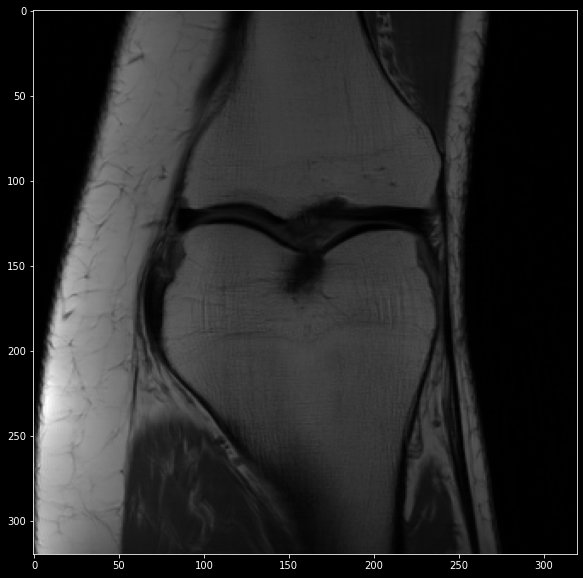

In [55]:
import matplotlib.pylab as plt
import fastmri

hf = h5py.File("../../log/reconstructions/file1000672_v2.h5")
recon = hf["reconstruction"][()]

_ = plt.imshow(recon[18], cmap="gray")

In [49]:
torch.Tensor(recon).shape

torch.Size([38, 320, 320])

In [43]:
from fastmri.pl_modules import FastMriDataModule, VarNetModule
from fastmri.data.transforms import VarNetDataTransform
from fastmri.data.subsample import create_mask_for_mask_type

# singlecoil or multicoil
challenge = "singlecoil"
# MASK_TYPE is either random (for knee) or equispaced (for brain)
mask_type = "random"
center_fractions = [0.08]
accelerations = [4]

mask = create_mask_for_mask_type(
    mask_type, center_fractions, accelerations
)

# use random masks for train transform, fixed masks for val transform
train_transform = VarNetDataTransform(mask_func=mask, use_seed=False)
val_transform = VarNetDataTransform(mask_func=mask)
test_transform = VarNetDataTransform()
    
data_module = FastMriDataModule(
    data_path=dataroot,
    challenge=challenge,
    train_transform=train_transform,
    val_transform=val_transform,
    test_transform=test_transform,
    test_path=test_path
)

# VarNet Model

In [44]:
model = VarNetModule(
    num_cascades=8,  # number of unrolled iterations
    pools=4,  # number of pooling layers for U-Net
    chans=18,  # number of top-level channels for U-Net
    sens_pools=4,  # number of pooling layers for sense est. U-Net
    sens_chans=8,  # number of top-level channels for sense est. U-Net
    lr=0.001,  # Adam learning rate
    lr_step_size=40,  # epoch at which to decrease learning rate
    lr_gamma=0.1,  # extent to which to decrease learning rate
    weight_decay=0.0,  # weight regularization strength
)

# Train model

In [45]:
trainer = pl.Trainer()
trainer.fit(model, datamodule=data_module)

GPU available: False, used: False
INFO:lightning:GPU available: False, used: False
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores

  | Name             | Type                 | Params
----------------------------------------------------------
0 | NMSE             | DistributedMetricSum | 0     
1 | SSIM             | DistributedMetricSum | 0     
2 | PSNR             | DistributedMetricSum | 0     
3 | ValLoss          | DistributedMetricSum | 0     
4 | TotExamples      | DistributedMetricSum | 0     
5 | TotSliceExamples | DistributedMetricSum | 0     
6 | varnet           | VarNet               | 20.1 M
7 | loss             | SSIMLoss             | 0     
----------------------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.478    Total estimated model params size (MB)
INFO:lightning:
  | Name             | Type                 | Params
---------------------------

ValueError: not enough values to unpack (expected 5, got 4)